# Implementation of method MOMENT on inverter data
presented by Goswami et al.


In [26]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import torch

In [27]:
def getSMAData():
    path_errors = './errortimestamps.csv'
    path_features = './featureslist.csv'
    df_errors = pd.read_csv(path_errors)
    df_features = pd.read_csv(path_features)
    total_features = list(df_features[(df_features['True/False'] == 'TRUE') | (df_features['True/False'] == 'NotAvailable')]['Features'])
    tot_feat = pd.read_csv('./totfeat.csv')
    tot_feat = list(tot_feat['feat'])
    xtrain_dfs = {}
    xtest_dfs = {}
    ytrain_dfs = {}
    ytest_dfs = {}
    for inverter in range(19):
        inv = 'inv_'+str(inverter)
        tot_feat.append('ErrBits')
        df_inv_0 = pd.read_csv('./downsampledata/'+str(inverter)+'.csv')
        df_inv_0['Timestamp'] = pd.to_datetime(df_inv_0['Timestamp'])
        df_inv_0.sort_values(by='Timestamp', inplace=True)
        df_inv_0 = df_inv_0.set_index(df_inv_0['Timestamp'])
        df_inv_0.shape


        format = '%Y-%m-%d %H:%M:%S'
        error_date = datetime.strptime(df_errors[(df_errors['Inverter'] == inverter) & (df_errors['had_failure'] == True)]['failure_time'].values[0][0:19], format)
        start_date = error_date-timedelta(days= 60)
        end_date = error_date+timedelta(days= 1*30)
        split_date = error_date-timedelta(days= 1*30)

        df_inv_0 = df_inv_0[(df_inv_0.index > start_date) & (df_inv_0.index < end_date)]
        df_inv_0 = pd.get_dummies(df_inv_0)

        for feat in tot_feat:
            if feat not in df_inv_0.columns:
                df_inv_0[feat] = 0
        df_inv_0 = df_inv_0[tot_feat]
        df_inv_0 = df_inv_0.dropna()
        df_target = df_inv_0[['ErrBits']]
        tot_feat.remove('ErrBits')
        df_inv_0 = df_inv_0[tot_feat]

        xtrain, xtest = df_inv_0[(df_inv_0.index >= start_date) & (df_inv_0.index< split_date)], df_inv_0[(df_inv_0.index >= split_date) & (df_inv_0.index< end_date)]
        ytrain, ytest = df_target[(df_target.index >= start_date) & (df_target.index< split_date)], df_target[(df_target.index >= split_date) & (df_target.index< end_date)]
        print(xtrain.shape, xtest.shape)
        xtrain_dfs[inv] = xtrain
        xtest_dfs[inv] = xtest
        ytrain_dfs[inv] = ytrain
        ytest_dfs[inv] = ytest
    return xtrain_dfs, xtest_dfs, ytrain_dfs, ytest_dfs

In [28]:
xtrain_dfs, xtest_dfs, ytrain_dfs, ytest_dfs = getSMAData()

(6057, 137) (11645, 137)
(6062, 137) (11231, 137)
(6180, 137) (11258, 137)
(5490, 137) (11139, 137)
(5516, 137) (10925, 137)
(5980, 137) (12281, 137)
(5923, 137) (10865, 137)
(6180, 137) (12319, 137)
(6180, 137) (8601, 137)
(6180, 137) (12146, 137)
(6165, 137) (11853, 137)
(6176, 137) (11752, 137)
(5741, 137) (12236, 137)
(6180, 137) (12122, 137)
(6159, 137) (12339, 137)
(6162, 137) (12333, 137)
(6180, 137) (12340, 137)
(6180, 137) (12339, 137)
(6180, 137) (12310, 137)


In [46]:
import torch

# Assuming xtest_inv_0 is a pandas DataFrame
xtest_inv_0 = xtest_dfs['inv_0']
channels = [xtest_inv_0[col].tolist() for col in xtest_inv_0.columns]

# Convert the list of lists into a tensor
tensor = torch.tensor(channels)  # Shape: [n_channels, n_time_points]

# Now we want to reshape this tensor into batches of 512 time points
window_size = 512
n_channels = tensor.shape[0]  # Should be 137
n_time_points = tensor.shape[1]  # Should be 11645

# How many full windows can we extract?
n_batches = n_time_points // window_size  # Floor division to get full batches

# Truncate the tensor to the largest number of full batches (if necessary)
tensor = tensor[:, :n_batches * window_size]  # Shape: [n_channels, n_batches * 512]

# Reshape into [batch_size, n_channels, window_size]
tensor = tensor.reshape(n_channels, n_batches, window_size).permute(1, 0, 2)
# Shape: [batch_size, n_channels, window_size]

print(tensor)  # Should output: [n_batches, 137, 512]


tensor([[[786.9214, 837.3190, 855.1500,  ...,   0.0000,   0.0000,   0.0000],
         [ 58.7314,  58.5238,  58.3914,  ...,  46.9729,  47.4610,  47.8633],
         [ 60.2279,  60.0802,  59.9510,  ...,  47.6507,  48.1593,  48.6002],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [ 61.1295,  61.1990,  61.0895,  ...,  47.2929,  47.7819,  48.2007],
         [ 65.1100,  65.1505,  65.0505,  ...,  48.0190,  48.6012,  49.0200]],

        [[  0.0000,   0.0000,   0.0000,  ..., 198.6738, 273.6571, 370.8238],
         [ 48.1988,  48.5143,  48.8143,  ...,  48.8845,  51.2983,  59.5193],
         [ 48.8731,  49.1490,  49.4086,  ...,  49.9517,  52.5526,  60.9936],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [ 48.5881,  48.8205,  49.0829,  ...,  49.0157,  51.8619,  60.7955],
         [ 49.3014,  49.5729,  49.8476,  ...,  51.2229,  54.1679,  63.6860]],

        [[436.1619, 473.3214, 534.7167,  ...

In [47]:
from torch.utils.data import DataLoader, TensorDataset
batch_size = 24
dataset = TensorDataset(tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
print(dataloader)

In [48]:
from momentfm import MOMENTPipeline
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={"task_name": "reconstruction"},  # For anomaly detection, we will load MOMENT in `reconstruction` mode
    # local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)
model.init()

In [49]:
output = model(tensor)

C:\Users\HOELKER\.virtualenvs\moment-main\Lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [57]:
print(output)

TimeseriesOutputs(forecast=None, anomaly_scores=None, logits=None, labels=None, input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]), pretrain_mask=tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), reconstruction=tensor([[[ 7.3894e+02,  7.1403e+02,  7.0204e+02,  ...,  1.0904e+02,
           1.1632e+02,  7.6445e+01],
         [ 5.7692e+01,  5.8436e+01,  5.8302e+01,  ...,  4.3135e+01,
           4.2184e+01,  4.2391e+01],
         [ 5.6350e+01,  5.6090e+01,  5.5822e+01,  ...,  4.3576e+01,
           4.4811e+01,  4.3445e+01],
         ...,
         [ 2.8082e-07, -1.7478e-06, -4.2229e-07,  ...,  4.5554e-09,
         

In [87]:
output_rec = output.reconstruction
anomaly_scores = (output_rec - tensor) ** 2
anomaly_scores

tensor([[[2.3020e+03, 1.5200e+04, 2.3444e+04,  ..., 1.1890e+04,
          1.3530e+04, 5.8439e+03],
         [1.0802e+00, 7.7120e-03, 8.0349e-03,  ..., 1.4727e+01,
          2.7843e+01, 2.9948e+01],
         [1.5034e+01, 1.5923e+01, 1.7051e+01,  ..., 1.6600e+01,
          1.1209e+01, 2.6581e+01],
         ...,
         [7.8860e-14, 3.0550e-12, 1.7833e-13,  ..., 2.0752e-17,
          3.9641e-13, 1.0718e-13],
         [5.9644e-01, 6.0544e-01, 1.2207e+00,  ..., 6.4473e+00,
          4.1665e+00, 6.7608e+00],
         [3.8605e+00, 5.5803e+00, 1.3370e+01,  ..., 5.6679e+01,
          2.9757e+01, 3.2525e+01]],

        [[1.2617e+04, 7.5883e+03, 5.2747e+03,  ..., 2.3492e+04,
          5.4831e+04, 9.8679e+04],
         [2.6333e+01, 1.8088e+01, 1.3874e+01,  ..., 1.0177e+01,
          1.1142e+01, 1.4677e+01],
         [4.6280e+00, 4.4630e+00, 1.5003e+00,  ..., 2.8867e+01,
          2.0782e+01, 1.1612e+02],
         ...,
         [3.9016e-13, 1.6769e-12, 2.1311e-12,  ..., 2.3217e-12,
          5.496

In [88]:
# Min-Max-Normalisierung zwischen 0 und 1
min_val = tensor.min()
max_val = tensor.max()

# Normierter Tensor
tensor_normalized = (tensor - min_val) / (max_val - min_val)
print(tensor_normalized)

tensor([[[4.8821e-06, 5.1324e-06, 5.2209e-06,  ..., 9.7338e-07,
          9.7338e-07, 9.7338e-07],
         [1.2651e-06, 1.2641e-06, 1.2634e-06,  ..., 1.2067e-06,
          1.2091e-06, 1.2111e-06],
         [1.2725e-06, 1.2718e-06, 1.2712e-06,  ..., 1.2101e-06,
          1.2126e-06, 1.2148e-06],
         ...,
         [9.7338e-07, 9.7338e-07, 9.7338e-07,  ..., 9.7338e-07,
          9.7338e-07, 9.7338e-07],
         [1.2770e-06, 1.2774e-06, 1.2768e-06,  ..., 1.2083e-06,
          1.2107e-06, 1.2128e-06],
         [1.2968e-06, 1.2970e-06, 1.2965e-06,  ..., 1.2119e-06,
          1.2148e-06, 1.2169e-06]],

        [[9.7338e-07, 9.7338e-07, 9.7338e-07,  ..., 1.9602e-06,
          2.3326e-06, 2.8153e-06],
         [1.2128e-06, 1.2143e-06, 1.2158e-06,  ..., 1.2162e-06,
          1.2282e-06, 1.2690e-06],
         [1.2161e-06, 1.2175e-06, 1.2188e-06,  ..., 1.2215e-06,
          1.2344e-06, 1.2763e-06],
         ...,
         [9.7338e-07, 9.7338e-07, 9.7338e-07,  ..., 9.7338e-07,
          9.733

In [95]:
mask = tensor_normalized > 0.8
mask

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [99]:
values_above_threshold = tensor[mask]

# Print the values that exceed the threshold
print("Values greater than the threshold:")
print(values_above_threshold)

# To print the indices as well, you can use .nonzero()
indices_above_threshold = mask.nonzero(as_tuple=False)

print("\nIndices of values greater than the threshold:")
print(indices_above_threshold)

# You can iterate over the indices and print the values with their positions
for idx in indices_above_threshold:
    print(f"Value: {tensor[tuple(idx)]}, Index: {tuple(idx)}")

Values greater than the threshold:
tensor([2.0133e+08, 2.0133e+08, 2.0133e+08,  ..., 2.0133e+08, 2.0133e+08,
        2.0133e+08])

Indices of values greater than the threshold:
tensor([[  0,  22,   0],
        [  0,  22,   1],
        [  0,  22,   2],
        ...,
        [ 21,  22, 509],
        [ 21,  22, 510],
        [ 21,  22, 511]])
Value: 201326592.0, Index: (tensor(0), tensor(22), tensor(0))
Value: 201326592.0, Index: (tensor(0), tensor(22), tensor(1))
Value: 201326592.0, Index: (tensor(0), tensor(22), tensor(2))
Value: 201326592.0, Index: (tensor(0), tensor(22), tensor(3))
Value: 201326592.0, Index: (tensor(0), tensor(22), tensor(4))
Value: 201326592.0, Index: (tensor(0), tensor(22), tensor(5))
Value: 201326592.0, Index: (tensor(0), tensor(22), tensor(6))
Value: 201326592.0, Index: (tensor(0), tensor(22), tensor(7))
Value: 201326592.0, Index: (tensor(0), tensor(22), tensor(8))
Value: 201326592.0, Index: (tensor(0), tensor(22), tensor(9))
Value: 201326592.0, Index: (tensor(0), 

In [35]:
anomaly_scores = []

with torch.no_grad():  # No need for gradient computation during evaluation
    for batch in dataloader:
        inputs = batch[0]  # Get the inputs from the batch
        print(batch[0])
        # Forward pass through the model
        outputs_rec = output.reconstruction
        print(outputs_rec)
        # Compute anomaly score (example: mean squared error between output and input)
        print((outputs_rec - inputs) ** 2)
        # mse = torch.mean((outputs_rec - inputs) ** 2, dim=1)
        # anomaly_scores.extend(mse.cpu().numpy())
        # print(mse)


tensor([[[786.9214, 837.3190, 855.1500,  ...,   0.0000,   0.0000,   0.0000],
         [ 58.7314,  58.5238,  58.3914,  ...,  46.9729,  47.4610,  47.8633],
         [ 60.2279,  60.0802,  59.9510,  ...,  47.6507,  48.1593,  48.6002],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [ 61.1295,  61.1990,  61.0895,  ...,  47.2929,  47.7819,  48.2007],
         [ 65.1100,  65.1505,  65.0505,  ...,  48.0190,  48.6012,  49.0200]]])
tensor([[[ 7.1013e+02,  7.1887e+02,  7.1059e+02,  ...,  1.1019e+02,
           8.1002e+01,  8.5873e+01],
         [ 5.8047e+01,  5.8041e+01,  5.7490e+01,  ...,  4.4067e+01,
           4.5353e+01,  4.5101e+01],
         [ 5.8139e+01,  5.8482e+01,  5.8636e+01,  ...,  4.2335e+01,
           4.4018e+01,  4.4151e+01],
         ...,
         [ 2.1269e-06, -7.1102e-07,  2.1732e-06,  ..., -1.2578e-06,
           2.8944e-06,  5.7797e-08],
         [ 5.9098e+01,  5.8418e+01,  5.8339e+01,  ...,  4.4028e+01,
           4.4862e+0

In [ ]:
import torch
from tqdm import tqdm

model = model.to("cuda").float()

trues, preds, labels = [], [], []
with torch.no_grad():
    for batch_x, batch_masks, batch_labels in tqdm(test_dataloader, total=len(test_dataloader)):
        batch_x = batch_x.to("cuda").float()
        batch_masks = batch_masks.to("cuda")

        output = model(batch_x, input_mask=batch_masks) # [batch_size, n_channels, window_size]

        trues.append(batch_x.detach().squeeze().cpu().numpy())
        preds.append(output.reconstruction.detach().squeeze().cpu().numpy())
        labels.append(batch_labels.detach().cpu().numpy())

<Axes: xlabel='Timestamp'>

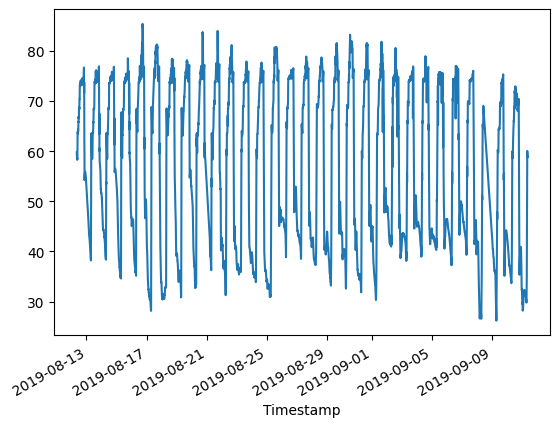

In [10]:
xtrain_dfs['inv_0']['TmpStk2_Igbt_PhsA_Bot'].plot()

<Axes: xlabel='Timestamp'>

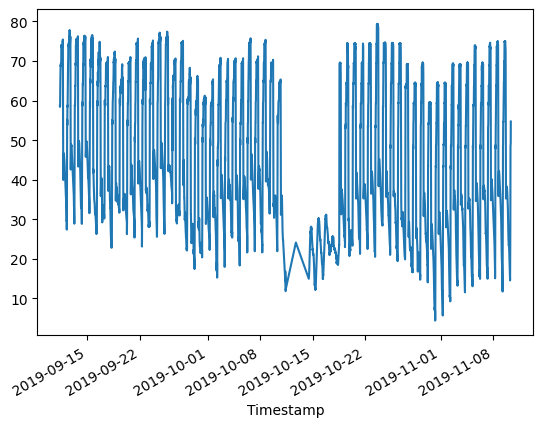

In [13]:
xtest_dfs['inv_0']['TmpStk2_Igbt_PhsA_Bot'].plot()

<Axes: xlabel='Timestamp'>

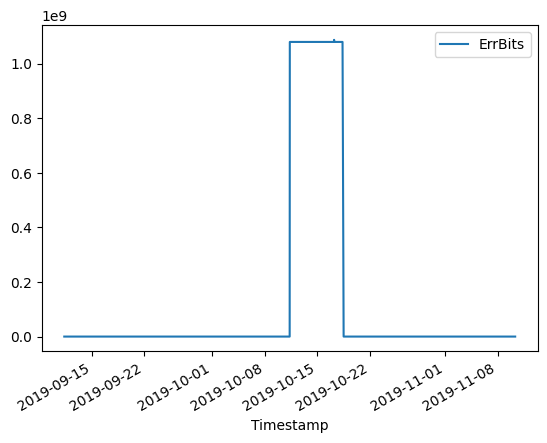

In [12]:
ytest_dfs['inv_0'].plot()